# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This is part of the Self Driving Car Nanodegree by Udacity.

The goal is to classify german traffic sign images with a deep learning model.

In this notebook I will give an overview of the data. Then images are normalized, so the minimum value of each image is 0 and the maximum value 255. Also the amount of images is increased by image augmentation techniques. These are changes in brightness (though they are not really visible after normalization), rotation, translation, scaling and sheering.

The deep learning model itself has the same architecture as the AlexNet, but the filter depth got increased as the images are in colour and therfore the input "depth" is bigger. As a result of the larger depth the fully connected layer has more neurons. I also added a dropout layer, as this net seems like overfitting the training examples. Without augmentation it reaches 100% classification on the test set quite early. Even with augmentation the net is overfitting. 

This net reached a validation accuracy of 94.1% and a validation accuracy of 95.5%. It is overfitting, but im running out of time to tweak the net even further.

---
## Step 0: Load The Data

Download and extract the file:

In [1]:
import urllib.request
import zipfile
import os.path
from os import makedirs

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip" 
local_file = "./data/traffic-signs-data.zip"

if not os.path.exists("./data"):
    os.makedirs("data")

if not os.path.exists(local_file):
    urllib.request.urlretrieve(url, local_file)
    print("Downloaded file")
    zip_ref = zipfile.ZipFile(local_file, 'r')
    zip_ref.extractall("./data/traffic-signs")
    zip_ref.close()
    print("Extracted file")
else:
    print("File already exists")


File already exists


In [2]:
# Load pickled data
import pickle

base_data_path = "./data/traffic-signs/"

training_file = base_data_path + "train.p"
validation_file= base_data_path + "test.p"
testing_file = base_data_path + "valid.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set 

In [3]:
import numpy as np

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# SOLUTION: Number of training examples
n_train = y_train.shape[0]

# SOLUTION: Number of validation examples
n_validation = y_valid.shape[0]

# SOLUTION: Number of testing examples.
n_test = y_test.shape[0]

# SOLUTION: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# SOLUTION: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [132]:
import matplotlib.pyplot as plt
%matplotlib inline

Lets take a look at the class distributions per set.

In [6]:
import pandas as pd
def class_histogram(labels, title_postfix = ""):
    pd.DataFrame(labels).hist(bins = n_classes, grid = False)
    plt.title("Distribution of Labels" + title_postfix)

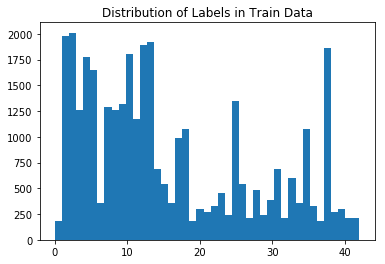

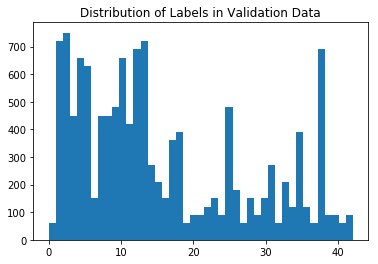

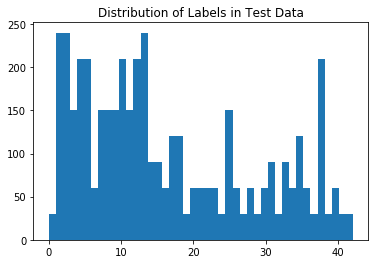

In [7]:
class_histogram(y_train, " in Train Data")
class_histogram(y_valid, " in Validation Data")
class_histogram(y_test, " in Test Data")

Class distribution is pretty much the same on each set, though there are more prominent classes than others.

Now lets take a look at some images of each class as they are ordered in the dataset.

In [8]:
def plot_classes(images_per_class, labels, images, shuffle_in_class = False):
    classes = pd.DataFrame({"Class": (labels)}).groupby("Class")
    number_of_classes = len(np.unique(labels))
    for group in classes:
        figure_number = 1
        for column in range(images_per_class):
            class_number = group[0]
            if shuffle_in_class:
                elements = group[1].sample(images_per_class).index
            else:
                elements = group[1].head(images_per_class).index
            
            plt.subplot(1, images_per_class, figure_number)
            plt.imshow(images[elements[column]])
            plt.axis('off')
            if(figure_number == int((images_per_class + 1) / 2)):
                 plt.title("Class: " + str(class_number) + " Images: " +  str(group[1].shape[0]))
            
            figure_number += 1
       
        plt.show()


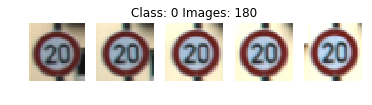

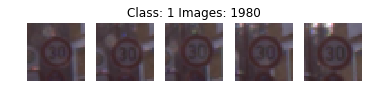

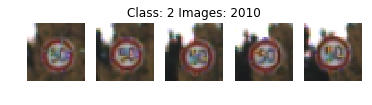

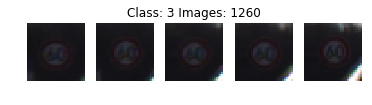

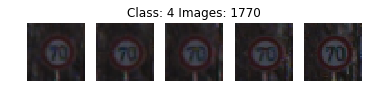

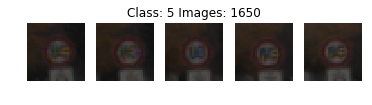

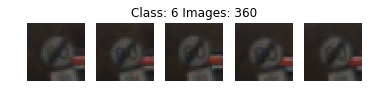

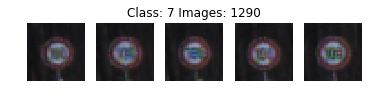

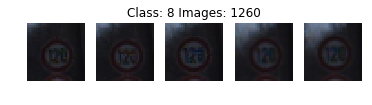

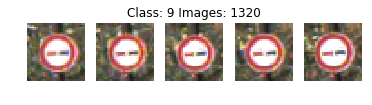

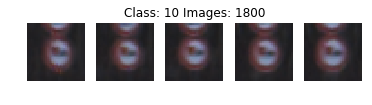

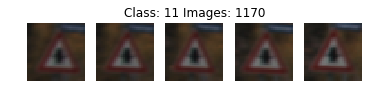

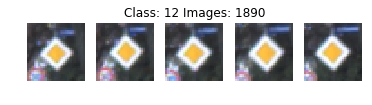

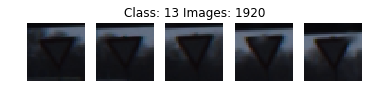

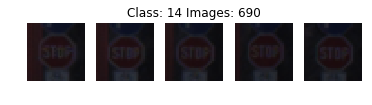

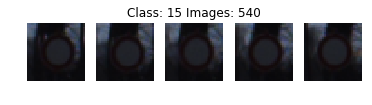

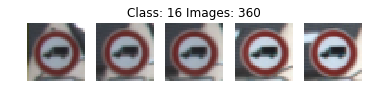

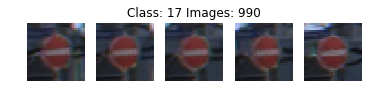

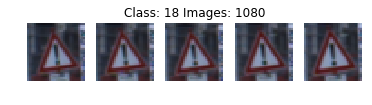

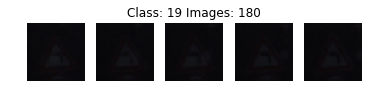

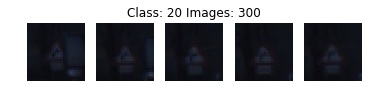

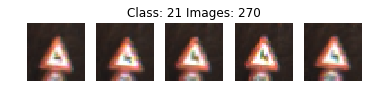

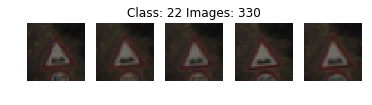

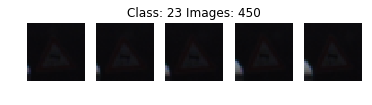

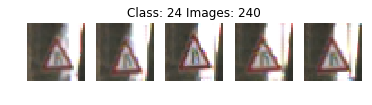

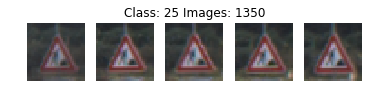

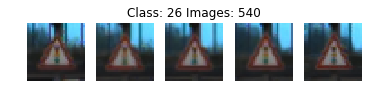

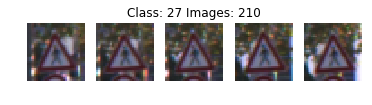

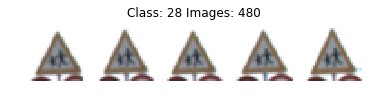

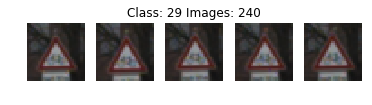

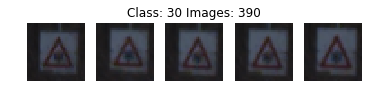

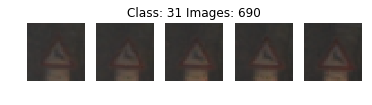

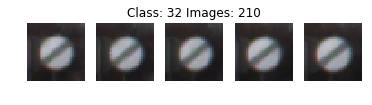

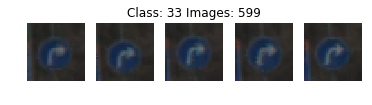

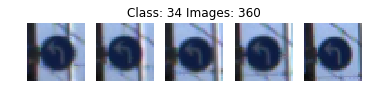

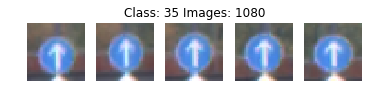

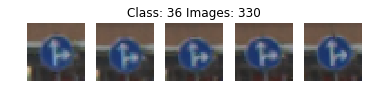

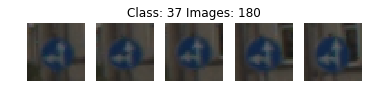

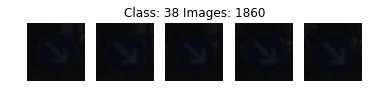

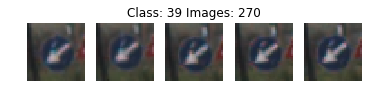

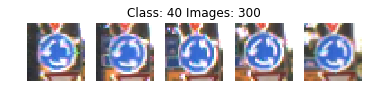

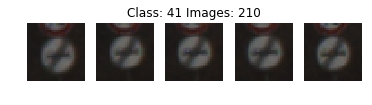

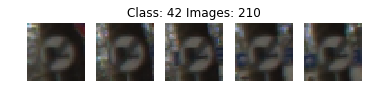

In [9]:
plot_classes(5, y_train, X_train)

The class distribution seem to be according to the distribution of the signs you see on german streets. For example class one, a speed limit of 20 km/h is very rare to see, as usally the speed limit in residential areas is 30 km/h.

As far as I know the images were taken from a car and multiple images of each sign were taken as the car moved by. Therfore the dateset contains the same image with different alterations in the angle or in brightness. Lets take a look at random pictures per class to see some different ones.

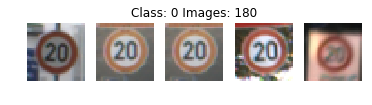

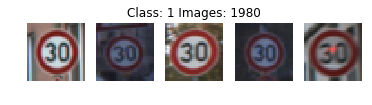

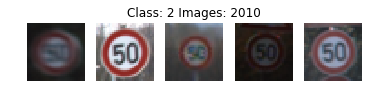

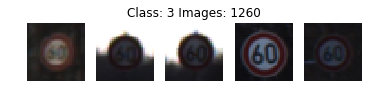

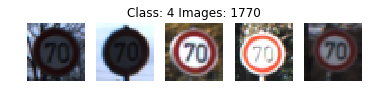

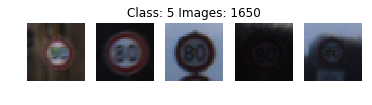

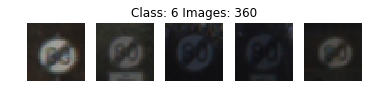

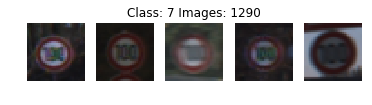

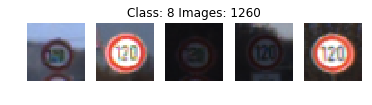

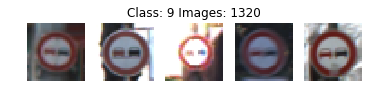

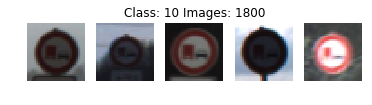

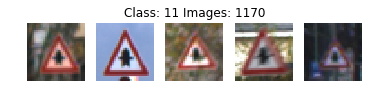

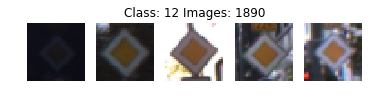

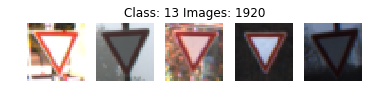

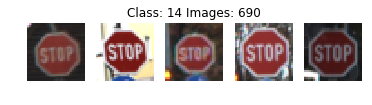

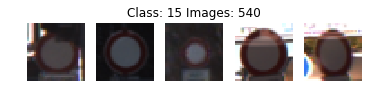

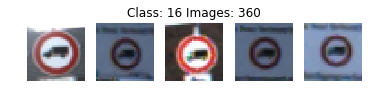

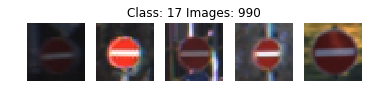

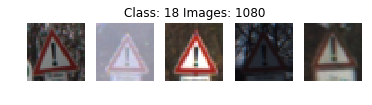

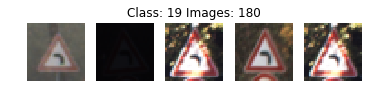

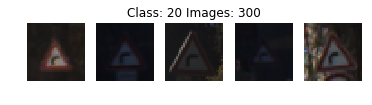

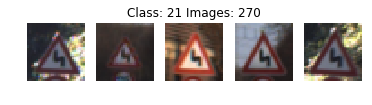

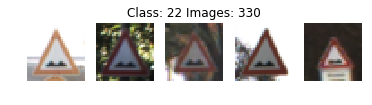

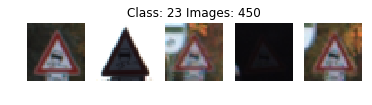

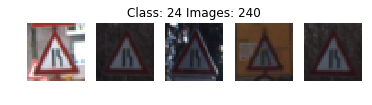

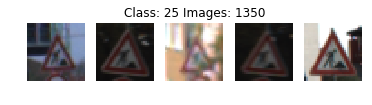

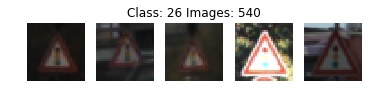

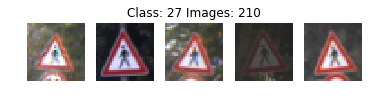

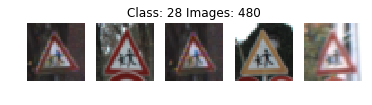

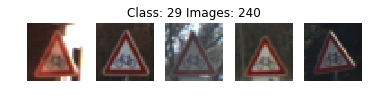

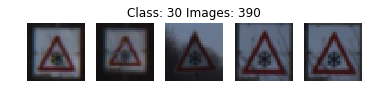

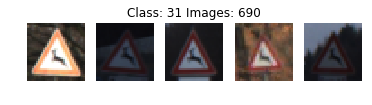

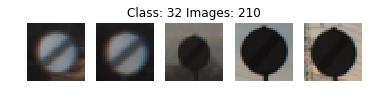

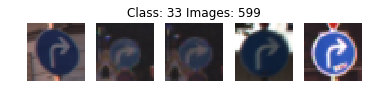

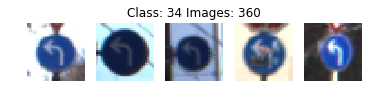

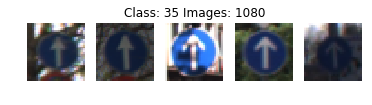

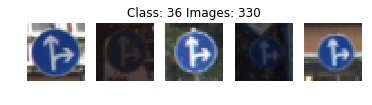

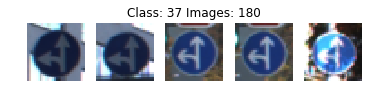

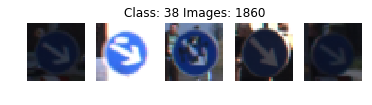

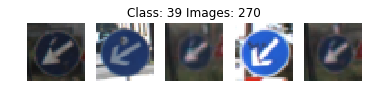

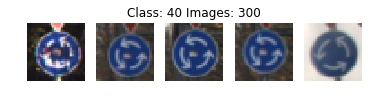

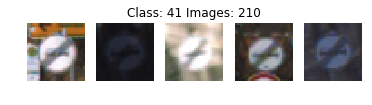

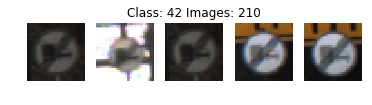

In [133]:
plot_classes(5, y_train, X_train, shuffle_in_class=True)

We will also take a look at the images in the validation and test set.

In [11]:
plot_classes(5, y_valid, X_valid, shuffle_in_class=True)

In [12]:
plot_classes(5, y_test, X_test, shuffle_in_class=True)

----

## Step 2: Model Architecture



### Pre-processing

In [14]:
def to_float_image(images):
    """
    Converts images in the range 0 - 255 to the range 0.0 - 1.0.
    This can still be plotted with matplotlib.
    """
    return images.astype(np.float32) / 255.0

In [69]:
def normalize(images):
    """
    The pixel values of a normalized image range from 0 to 255. 
    So if an images darkest pixel is 10 and brightest pixel is 200,
    after normalzing they are 0 and 255. All other pixel values are 
    scaled accordingly.
    """
    result = np.empty(images.shape)
    for i in range(len(images)):
        image = images[i].astype(np.float32)
        image -= image.min()
        image *= (255.0/image.max())
        result[i] = image
    return result.astype(np.ubyte)

In [16]:
def float_image_to_deep_learning_input(images):
    """
    Input should have values in the range 0.0 - 1.0.
    Returns images in the range -1.0 - 1.0.
    This can not be plotted with matplotlib.
    """
    return (images - 0.5) * 2

In [94]:
from skimage import transform as itrf
def augment_image(image):
    """
    Adds random brightnes, shearing, rotation, translation and scaling to the image.
    """
    random_brightnes = np.clip(np.random.normal(loc = 1.0, scale = 0.5), 0.1, 3.0)
    image = np.clip((image * random_brightnes),0, 255).astype(np.ubyte)
    image = normalize(image)
    
    random_shear = np.random.normal(loc = 0.0, scale = 0.1)
    random_scale = (np.random.normal(loc = 1.0, scale = 0.1), np.random.normal(loc = 1.0, scale = 0.1))
    random_rotation = np.random.normal(loc = 0.0, scale = 0.1)
    random_translation = (np.random.normal(loc = 0.0, scale = 0.1), np.random.normal(loc = 0.0, scale = 0.1))
    afine_tf = itrf.AffineTransform(shear = random_shear, scale = random_scale, rotation = random_rotation)
    # print("Shear: " +  str(random_shear) + " Scale: " +  str(random_scale) + " Rot: " + str(random_rotation) + " Bright: " + str(random_brightnes))
    return itrf.warp(image, inverse_map=afine_tf)

Example of one image augmentation. (Execute multiple times to see the randomness)

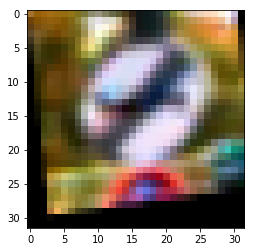

In [108]:
plt.imshow(augment_image(X_train[100]))

In [19]:
def image_augmentation_pipeline(images):
    result = np.zeros(images.shape)
    for i in range(len(images)):
        result[i] = augment_image(images[i])
    
    return result

In [83]:
def prepare_images_for_deep_learning(images):
    images = normalize(images)
    images = to_float_image(images)
    images = float_image_to_deep_learning_input(images)
    return images

### Augmentation 

In [119]:
%%time
AUGMENTATION_RUNS = 5
X_train_augmented =  np.zeros((AUGMENTATION_RUNS,) + X_train.shape)
for i in range(AUGMENTATION_RUNS):
    X_train_augmented[i] = image_augmentation_pipeline(X_train)
    

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3min 28s, sys: 0 ns, total: 3min 28s
Wall time: 3min 26s


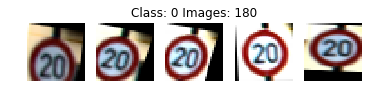

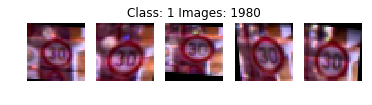

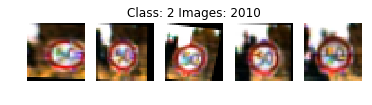

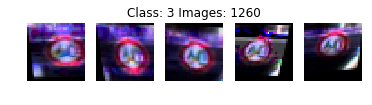

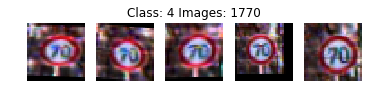

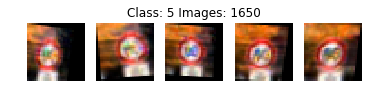

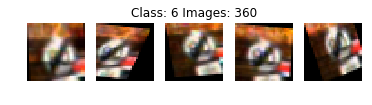

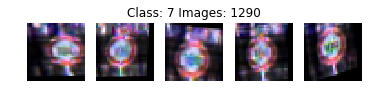

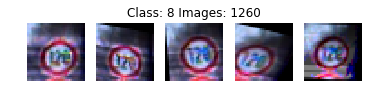

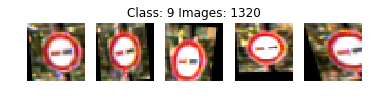

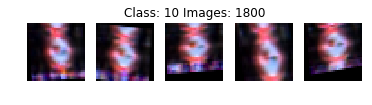

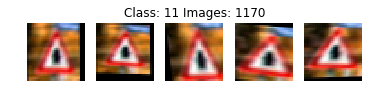

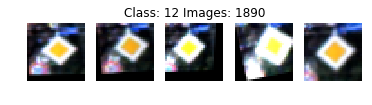

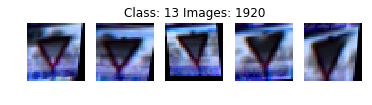

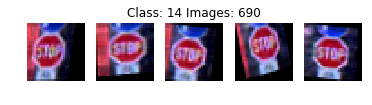

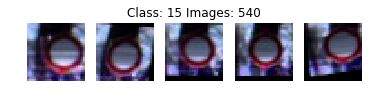

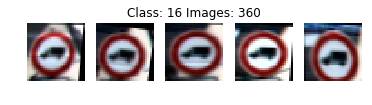

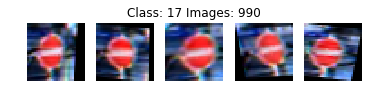

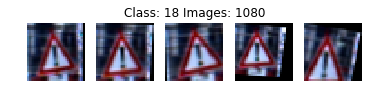

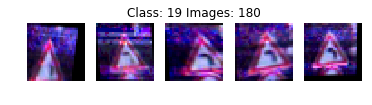

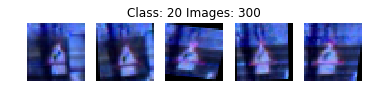

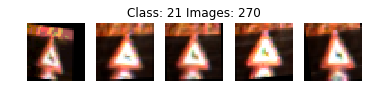

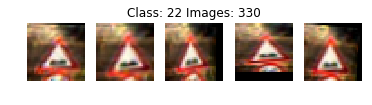

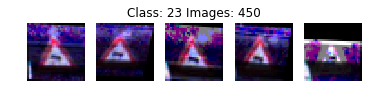

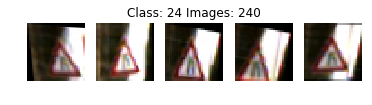

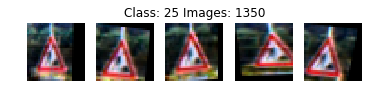

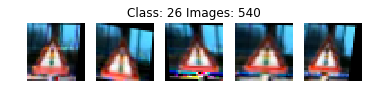

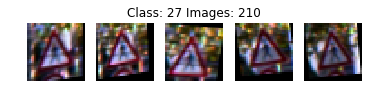

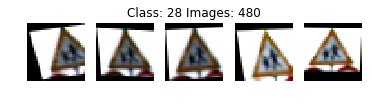

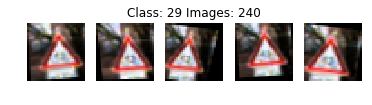

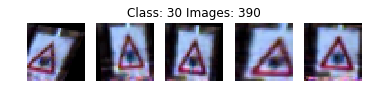

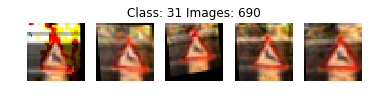

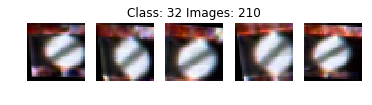

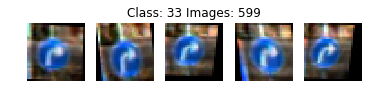

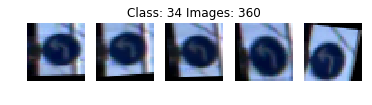

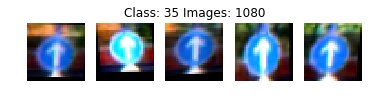

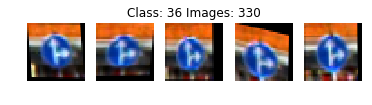

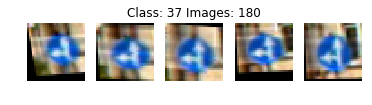

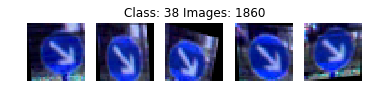

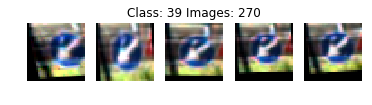

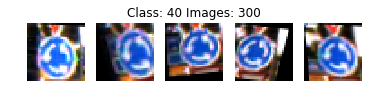

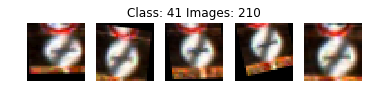

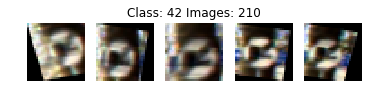

In [110]:
plot_classes(5, y_train, X_train_augmented[0], shuffle_in_class=False)

### Image Preparation for Deep Learning

In [120]:
X_train_prepared = prepare_images_for_deep_learning(X_train)
X_train_augmented_prepared = prepare_images_for_deep_learning(X_train_augmented)
X_test_prepared = prepare_images_for_deep_learning(X_test)
X_valid_prepared = prepare_images_for_deep_learning(X_valid)

### Model Architecture

In [122]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x36. Output = 900.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 800. Output = 200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(800, 200), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(200))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 200. Output = 100.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(100))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    drop = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 100. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(drop, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Variables

In [124]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3), name= "x")
y = tf.placeholder(tf.int32, (None), name= "y")
one_hot_y = tf.one_hot(y, 43, name= "one_hot_encoder")
keep_prob = tf.placeholder(tf.float32)

Training Pipeline

In [125]:
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

Evaluation

In [126]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))

    return total_accuracy / num_examples, total_loss / num_examples

Training

Training...

EPOCH 1 ...
Train Accuracy = 0.693
Validation Accuracy = 0.638
Validation Loss = 1.2364612636

EPOCH 2 ...
Train Accuracy = 0.914
Validation Accuracy = 0.843
Validation Loss = 0.567817375307

EPOCH 3 ...
Train Accuracy = 0.959
Validation Accuracy = 0.887
Validation Loss = 0.413956645058

EPOCH 4 ...
Train Accuracy = 0.977
Validation Accuracy = 0.906
Validation Loss = 0.353605489998

EPOCH 5 ...
Train Accuracy = 0.985
Validation Accuracy = 0.911
Validation Loss = 0.318117147448

EPOCH 6 ...
Train Accuracy = 0.989
Validation Accuracy = 0.917
Validation Loss = 0.299391308458

EPOCH 7 ...
Train Accuracy = 0.992
Validation Accuracy = 0.927
Validation Loss = 0.273778453292

EPOCH 8 ...
Train Accuracy = 0.993
Validation Accuracy = 0.929
Validation Loss = 0.281320402675

EPOCH 9 ...
Train Accuracy = 0.994
Validation Accuracy = 0.927
Validation Loss = 0.284150998331

EPOCH 10 ...
Train Accuracy = 0.995
Validation Accuracy = 0.929
Validation Loss = 0.262437562256

EPOCH 11 ...
Train

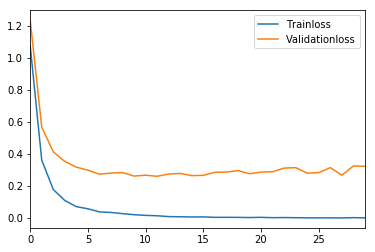

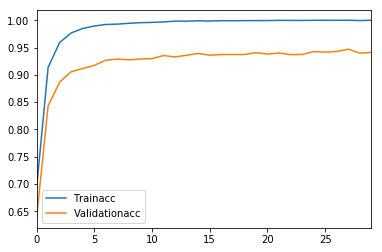

In [127]:
%%time
from sklearn.utils import shuffle

EPOCHS = 30
BATCH_SIZE = 512
dropout = 0.5


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_prepared)
    
    train_losses = []
    validation_losses = []
    
    train_accs = []
    validation_accs = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        # Shuffle normal images.
        X_train_shuffled, y_train_shuffled = shuffle(X_train_prepared, y_train)
        
        # Shuffle augmentated images.
        for k in range(AUGMENTATION_RUNS):
            X_train_augmented_shuffled = np.zeros(X_train_augmented_prepared.shape)
            y_train_augmented_shuffled = np.zeros((AUGMENTATION_RUNS,) + y_train.shape)
            X_train_augmented_shuffled[k], y_train_augmented_shuffled[k] = shuffle(X_train_augmented_prepared[k], y_train)

        # Do Batch runs.
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_shuffled[offset:end], y_train_shuffled[offset:end]
            
            # do a normal run.
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
            # do runs with augmentated images.
            for augmentation_run in range(AUGMENTATION_RUNS):
                augmented_batch_x, augmented_batch_y = X_train_augmented_shuffled[augmentation_run][offset:end], y_train_augmented_shuffled[augmentation_run][offset:end]
                sess.run(training_operation, feed_dict={x: augmented_batch_x, y: augmented_batch_y, keep_prob: dropout})
       
        # Calculate and print losses and accuracies.
        train_accuracy, train_loss = evaluate(X_train_prepared, y_train)
        validation_accuracy, validation_loss = evaluate(X_valid_prepared, y_valid)
        
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        
        train_accs.append(train_accuracy)
        validation_accs.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Train Accuracy = {0:.3f}".format(train_accuracy))
        print("Validation Accuracy = {0:.3f}".format(validation_accuracy))
        print("Validation Loss = " + str(validation_loss))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
    
    pd.DataFrame({"Trainloss": train_losses, "Validationloss": validation_losses}).plot()
    pd.DataFrame({"Trainacc": train_accs, "Validationacc": validation_accs}).plot()

Final test

In [131]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy, test_loss = evaluate(X_test_prepared, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.955


### Missclassified Images

In [213]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    prediction = tf.argmax(logits,1)
    pred = sess.run(prediction, feed_dict = {x: X_test_prepared,  keep_prob: 1.0})
 

In [234]:
from sklearn.metrics import confusion_matrix

def plot_nth_most_confused(n, true_values, predicted_values):
    conf = confusion_matrix(true_values, predicted_values)
    np.fill_diagonal(conf, 0)

    flat = conf.flatten()
    flat.sort()

    real, pred = np.where(conf == flat[-n])
    real_class = np.where(y_test == real)[0][0]
    pred_class = np.where(y_test == pred)[0][0]
    plt.subplot(1, 2, 1)
    plt.imshow((X_test[real_class]))
    plt.title("Real Class: " +  str(real) + " Prediction: " +  str(pred))
    plt.subplot(1, 2, 2)
    plt.imshow((X_test[pred_class]))


This are examples for the most confused classes from most confusions to less confusions. The signs are very similiar indeed. 

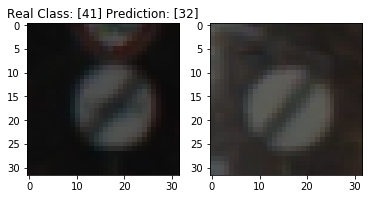

In [235]:
plot_nth_most_confused(1, y_test, pred)

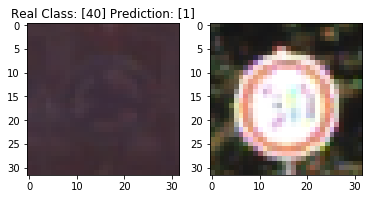

In [236]:
plot_nth_most_confused(2, y_test, pred)

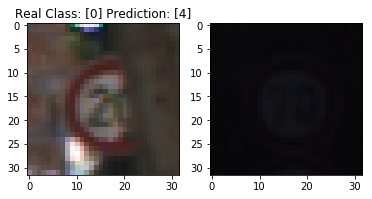

In [237]:
plot_nth_most_confused(3, y_test, pred)

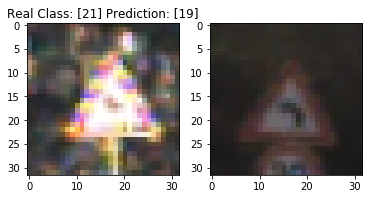

In [238]:
plot_nth_most_confused(4, y_test, pred)

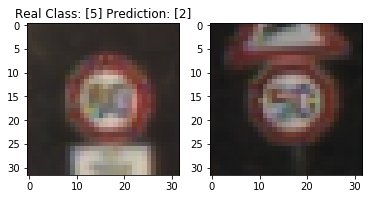

In [240]:
plot_nth_most_confused(5, y_test, pred)

Compare with this list, as the shown images are not good representatives sometimes. This shows that this task is even hard for humans. Some of the example images are not recognizable unfortunatly.

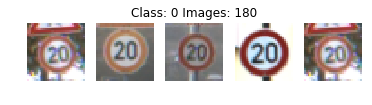

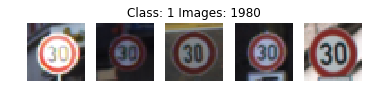

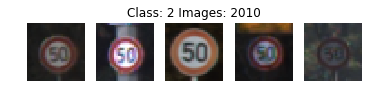

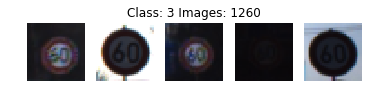

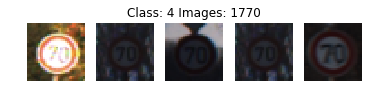

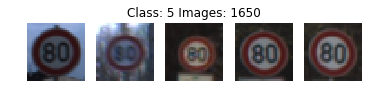

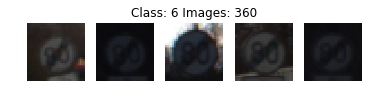

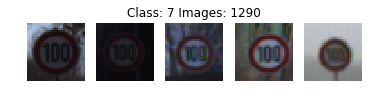

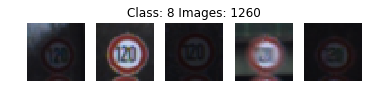

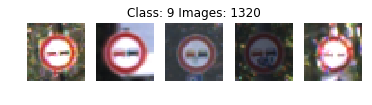

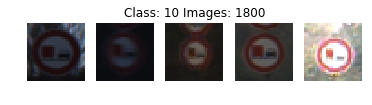

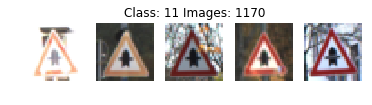

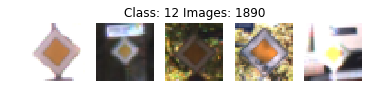

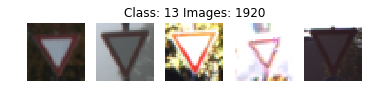

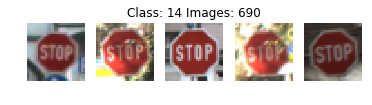

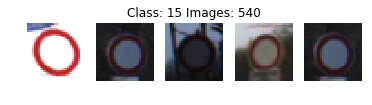

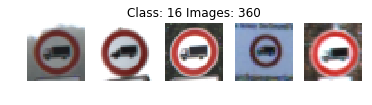

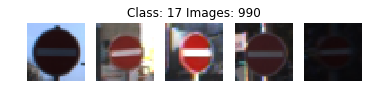

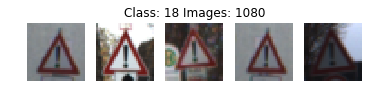

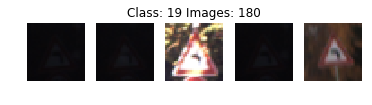

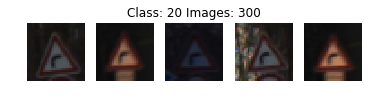

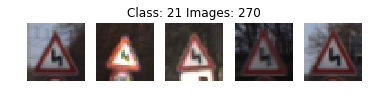

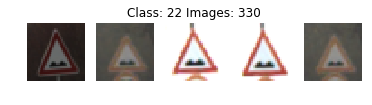

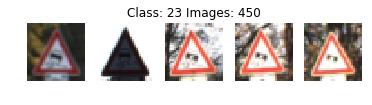

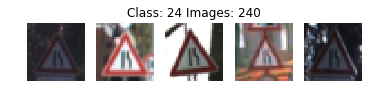

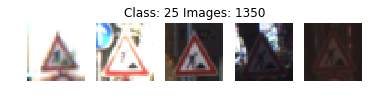

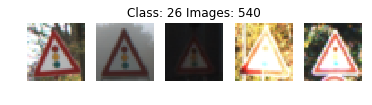

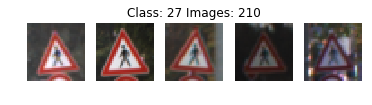

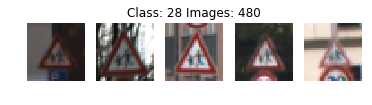

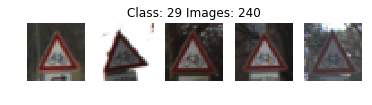

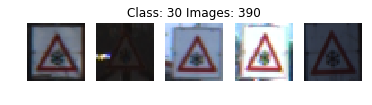

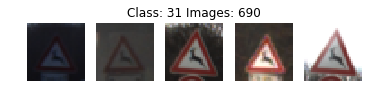

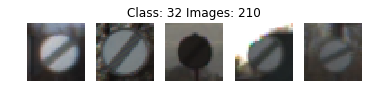

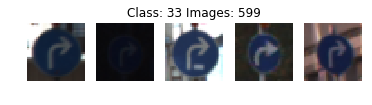

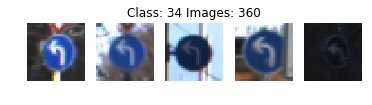

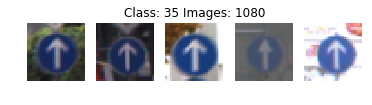

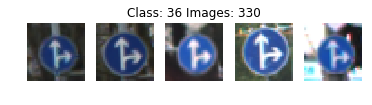

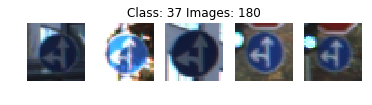

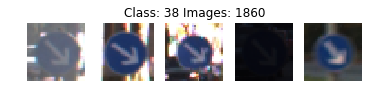

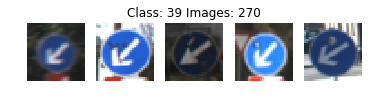

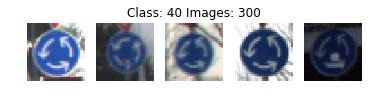

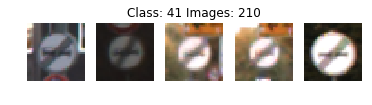

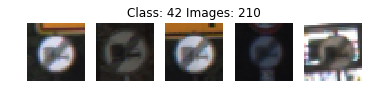

In [239]:
plot_classes(5, y_train, X_train, shuffle_in_class=True)

---

## Step 3: Test a Model on New Images

As I life in Germany, I drove around and took some images. I mounted my Phone behind my windshield to take the images. The windscreen was quite dirty, from time to time it was raining. So the images will be challenging.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")